install dan report

In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
BASE_DIR = "/content/drive/MyDrive/card_project"
DATASET_DIR = f"{BASE_DIR}/dataset"
MODEL_DIR = f"{BASE_DIR}/models"

!mkdir -p $DATASET_DIR
!mkdir -p $MODEL_DIR

!ls $BASE_DIR


'archive (6).zip'   dataset   models


In [20]:
!unzip -q "/content/drive/MyDrive/card_project/archive (6).zip" -d $DATASET_DIR


replace /content/drive/MyDrive/card_project/dataset/14card types-14-(200 X 200)-94.61.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
!ls $DATASET_DIR


'14card types-14-(200 X 200)-94.61.h5'	 cards.csv   train
'53cards-53-(200 X 200)-100.00.h5'	 test	     val


In [22]:
!mv /content/drive/MyDrive/card_project/dataset/valid /content/drive/MyDrive/card_project/dataset/val


mv: cannot stat '/content/drive/MyDrive/card_project/dataset/valid': No such file or directory


In [23]:
!mv $DATASET_DIR/valid $DATASET_DIR/val
!ls $DATASET_DIR


mv: cannot stat '/content/drive/MyDrive/card_project/dataset/valid': No such file or directory
'14card types-14-(200 X 200)-94.61.h5'	 cards.csv   train
'53cards-53-(200 X 200)-100.00.h5'	 test	     val


In [8]:
import os

TRAIN_DIR = f"{DATASET_DIR}/train"

classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

print("Jumlah kelas:", len(classes))
print("Contoh kelas:", classes[:10])


Jumlah kelas: 53
Contoh kelas: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds']


In [9]:
!pip -q install torch torchvision opencv-python scikit-learn matplotlib


In [10]:
import cv2, json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small


In [11]:
def preprocess_rgb(img_rgb):
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    bgr = cv2.GaussianBlur(bgr, (5,5), 0)
    bgr = cv2.medianBlur(bgr, 3)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    l2 = clahe.apply(l)
    lab = cv2.merge([l2,a,b])
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


In [12]:
class CardDataset(Dataset):
    def __init__(self, root, classes):
        self.samples = []
        for i, c in enumerate(classes):
            cdir = os.path.join(root, c)
            for f in os.listdir(cdir):
                if f.lower().endswith((".jpg",".png",".jpeg",".webp")):
                    self.samples.append((os.path.join(cdir,f), i))

        self.tf = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],
                                 [0.229,0.224,0.225])
        ])

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        path, y = self.samples[i]
        img = Image.open(path).convert("RGB")
        img = preprocess_rgb(np.array(img))
        return self.tf(Image.fromarray(img)), y


train_ds = CardDataset(f"{DATASET_DIR}/train", classes)
val_ds   = CardDataset(f"{DATASET_DIR}/val", classes)
test_ds  = CardDataset(f"{DATASET_DIR}/test", classes)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

print(len(train_ds), len(val_ds), len(test_ds))


7624 265 265


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = mobilenet_v3_small(weights="DEFAULT")
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(classes))
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 53.1MB/s]


In [15]:
EPOCHS = 5
for e in range(EPOCHS):
    model.train()
    correct = total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = loss_fn(out,y)
        loss.backward()
        opt.step()
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    train_acc = correct/total

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_acc = correct/total
    print(f"Epoch {e+1}/{EPOCHS} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")


Epoch 1/5 | train_acc=0.5592 val_acc=0.7472
Epoch 2/5 | train_acc=0.7037 val_acc=0.8491
Epoch 3/5 | train_acc=0.7751 val_acc=0.8642
Epoch 4/5 | train_acc=0.8223 val_acc=0.8868
Epoch 5/5 | train_acc=0.8644 val_acc=0.8981


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# REPORT
report = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
)

print("=== Classification Report ===")
print(report)


=== Classification Report ===
                   precision    recall  f1-score   support

     ace of clubs     1.0000    1.0000    1.0000         5
  ace of diamonds     1.0000    1.0000    1.0000         5
    ace of hearts     0.8333    1.0000    0.9091         5
    ace of spades     1.0000    1.0000    1.0000         5
   eight of clubs     1.0000    1.0000    1.0000         5
eight of diamonds     0.8333    1.0000    0.9091         5
  eight of hearts     1.0000    1.0000    1.0000         5
  eight of spades     0.6667    0.8000    0.7273         5
    five of clubs     1.0000    1.0000    1.0000         5
 five of diamonds     1.0000    0.8000    0.8889         5
   five of hearts     1.0000    1.0000    1.0000         5
   five of spades     0.8000    0.8000    0.8000         5
    four of clubs     0.8333    1.0000    0.9091         5
 four of diamonds     1.0000    1.0000    1.0000         5
   four of hearts     1.0000    1.0000    1.0000         5
   four of spades     1.0

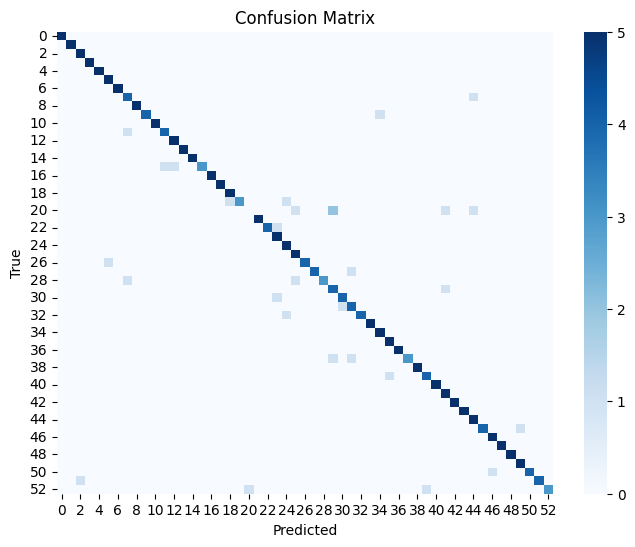

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", cbar=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
torch.save(model.state_dict(), f"{MODEL_DIR}/mobilenetv3_card.pth")

with open(f"{MODEL_DIR}/labels.json","w") as f:
    json.dump(classes, f, indent=2)

!ls $MODEL_DIR


labels.json  mobilenetv3_card.pth


In [17]:
from google.colab import files
files.download(f"{MODEL_DIR}/mobilenetv3_card.pth")
files.download(f"{MODEL_DIR}/labels.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>